**Step 1: Import dependencies; load and analyze the spam text data**

In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
%matplotlib inline

In [3]:
# library for train test split
from sklearn.model_selection import train_test_split

In [4]:
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [6]:
#load data
path = "spam.csv"
messages = pd.read_csv(path, header=0,usecols=['v1', 'v2'], encoding='latin-1')
messages[:3]

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [7]:
messages.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

      v1                                                 v2
102  ham  As per your request 'Melle Melle (Oru Minnamin...
153  ham  As per your request 'Melle Melle (Oru Minnamin...
206  ham  As I entered my cabin my PA said, '' Happy B'd...
222  ham                             Sorry, I'll call later
325  ham                   No calls..messages..missed calls


In [9]:
messages.groupby('v1').describe().T

v1                            ham  \
v2 count                     4825   
   unique                    4516   
   top     Sorry, I'll call later   
   freq                        30   

v1                                                      spam  
v2 count                                                 747  
   unique                                                653  
   top     Please call our customer service representativ...  
   freq                                                    4

In [11]:
# Get all the ham and spam messages
ham_msg = messages[messages.v1 =='ham']
spam_msg = messages[messages.v1=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_txt = " ".join(ham_msg.v2.to_numpy().tolist())
spam_msg_txt = " ".join(spam_msg.v2.to_numpy().tolist())

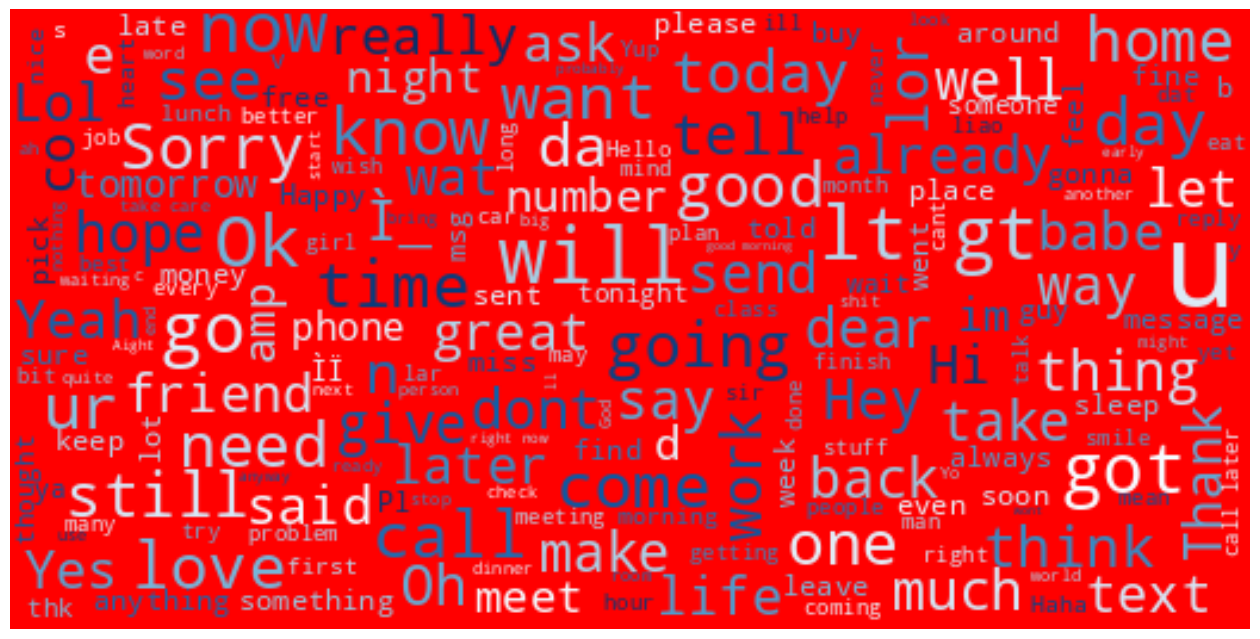

In [12]:
# wordcloud of ham messages
ham_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="red", colormap='Blues').generate(ham_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

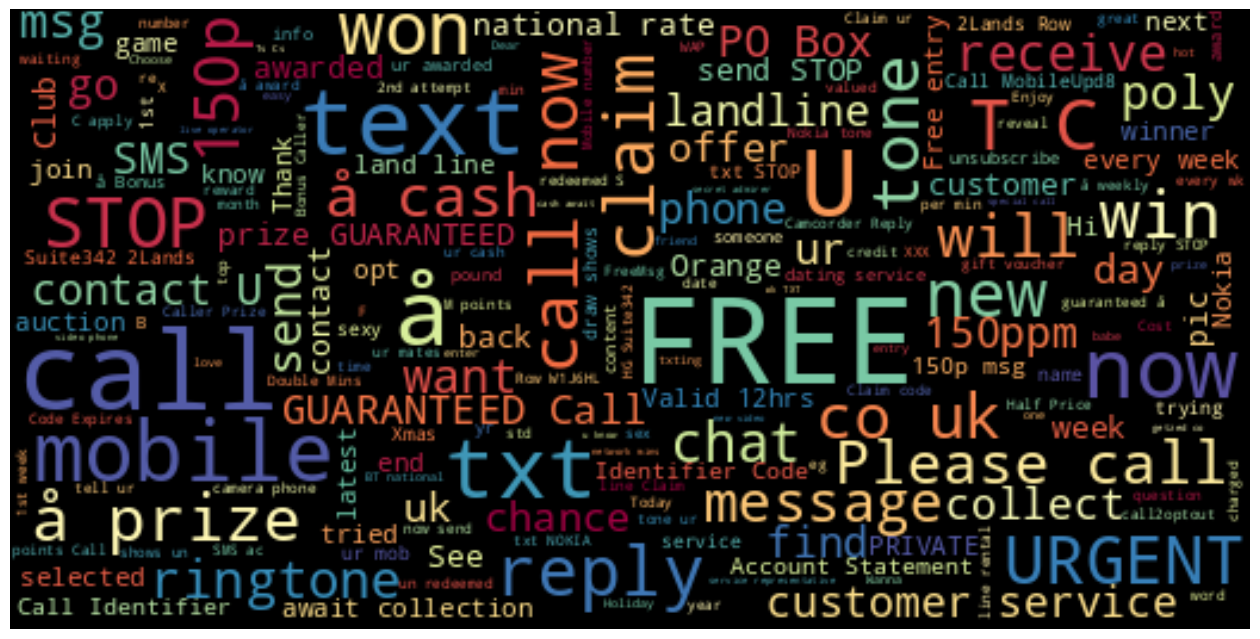

In [13]:
# wordcloud of spam messages
spam_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Spectral_r').generate(spam_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.481865284974095

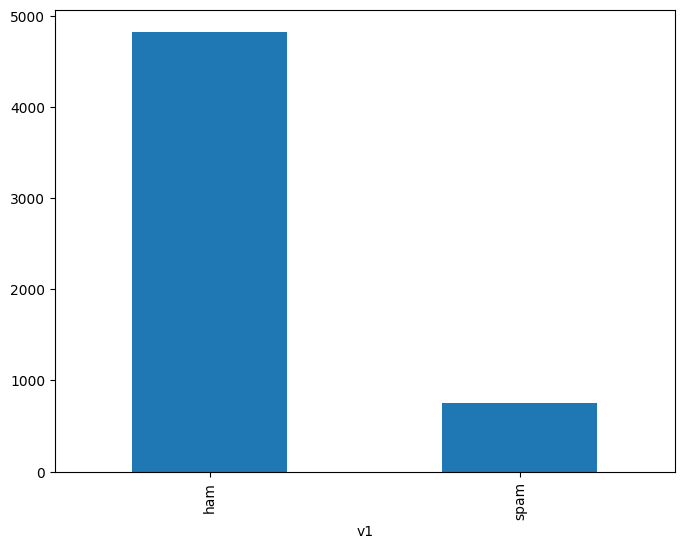

In [14]:
#visualize imbalanced data 
plt.figure(figsize=(8,6))
#sns.countplot(messages.v1)
counts = messages.groupby('v1').size()
counts.plot.bar()
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

(747, 2) (747, 2)


Text(0.5, 0, 'Message labels')

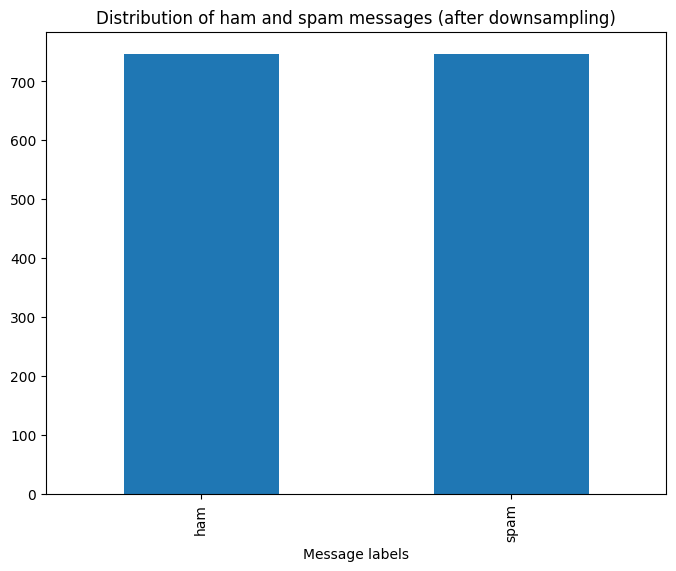

In [15]:
# one way to fix imbalanced data is to downsample the ham message count to the spam message count
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

#check the shape now, it must be the same!
print(ham_msg_df.shape, spam_msg_df.shape)

#check graph for better visualization 
msg_df = pd.concat([ham_msg_df, spam_msg_df], ignore_index=True)
plt.figure(figsize=(8,6))
counts = msg_df.groupby('v1').size()
counts.plot.bar()
#sns.countplot(msg_df.v1)
plt.title('Distribution of ham and spam messages (after downsampling)')
plt.xlabel('Message labels')

In [16]:
# Get length column for each text
msg_df['text_length'] = msg_df['v2'].apply(len)

#Calculate average length by label types
#labels = msg_df.groupby('v1').mean()
labels = msg_df.groupby('v1').mean(numeric_only=True)
labels

,text_length
v1,
ham,69.626506
spam,138.866131


### **Step 2: Split the data into train and test sub-datasets; text preprocessing**


In [17]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['v1'].map({'ham': 0, 'spam': 1})
msg_v1 = msg_df['msg_type'].values

In [18]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['v2'], msg_v1, test_size=0.2, random_state=434)

In [19]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [20]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [21]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 '2': 13,
 'and': 14,
 'free': 15,
 'in': 16,
 'or': 17,
 'have': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 'are': 24,
 '4': 25,
 'from': 26,
 'me': 27,
 'text': 28,
 'get': 29,
 'stop': 30,
 'mobile': 31,
 'my': 32,
 'this': 33,
 'be': 34,
 'just': 35,
 'claim': 36,
 'only': 37,
 'it': 38,
 'reply': 39,
 'that': 40,
 'www': 41,
 'no': 42,
 'out': 43,
 'will': 44,
 'at': 45,
 'we': 46,
 'do': 47,
 'so': 48,
 'send': 49,
 'our': 50,
 'not': 51,
 'prize': 52,
 'new': 53,
 'if': 54,
 'cash': 55,
 'but': 56,
 'go': 57,
 'can': 58,
 '150p': 59,
 'up': 60,
 'uk': 61,
 "i'm": 62,
 'please': 63,
 'nokia': 64,
 'who': 65,
 'win': 66,
 't': 67,
 'won': 68,
 '1': 69,
 'all': 70,
 'tone': 71,
 'what': 72,
 'week': 73,
 'com': 74,
 'been': 75,
 'msg': 76,
 'want': 77,
 'phone': 78,
 'know': 79,
 '50': 80,
 'service': 81,
 'by': 82,
 'urgent': 83,
 '

In [22]:
# check how many unique tokens are present
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4054 unique tokens in training data. 


In [23]:
# Sequencing and padding 
#train
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
#test
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

# **Step 3: Training the model**


In [24]:
#The Dense Sequential Spam Detection Model architecture
vocab_size = 500 
embeding_dim = 16
drop_value = 0.2 
n_dense = 24
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [26]:
# fit dense seq model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6884 - accuracy: 0.7230 - val_loss: 0.6815 - val_accuracy: 0.8261 - 2s/epoch - 57ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6669 - accuracy: 0.8243 - val_loss: 0.6549 - val_accuracy: 0.7993 - 139ms/epoch - 4ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6207 - accuracy: 0.8561 - val_loss: 0.5977 - val_accuracy: 0.8428 - 124ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5376 - accuracy: 0.8703 - val_loss: 0.5083 - val_accuracy: 0.8662 - 104ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4398 - accuracy: 0.8921 - val_loss: 0.4088 - val_accuracy: 0.8763 - 101ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3470 - accuracy: 0.9213 - val_loss: 0.3233 - val_accuracy: 0.9130 - 117ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2708 - accuracy: 0.9247 - val_loss: 0.2598 - val_accuracy: 0.9264 - 114ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2191 - accuracy: 0.9414 - val_loss: 0.2189 - val_accuracy: 0.9331 - 107ms/epoch - 3ms/step
Epoch 9/30
38/38 -

In [27]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 7ms/step - loss: 0.0901 - accuracy: 0.9699


[0.09008777141571045, 0.9698996543884277]

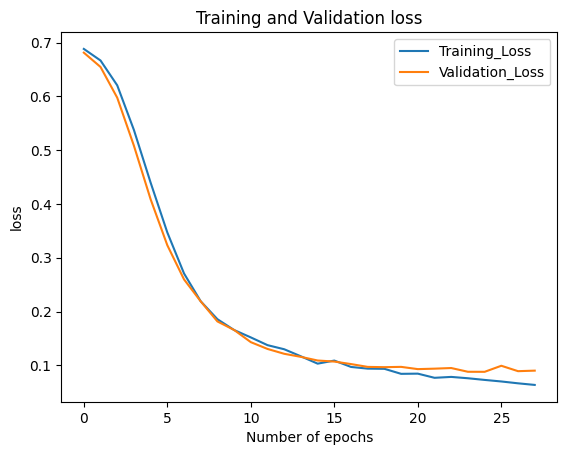

In [28]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

# **Step 5: Using the model to predict whether its spam or ham by giving text from the original data.**

In [29]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 95ms/step


array([[0.01061182],
       [0.01469253],
       [0.99999374]], dtype=float32)